<a href="https://colab.research.google.com/github/sankalpachowdhury/Fractal_Analysis/blob/master/Higuchi_Fractal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#C codes

In [ ]:
#include <stdio.h>

int main()
{
   int i, j, k, m, n, s=0, l, x=0;
   printf("Enter sample size:");
   scanf("%d",&n);
   printf("Enter largest time delay parameter:");
   scanf("%d",&k);
   int a[n];
   for(i=2;i<=k;i++)
   {
       for(m=0;m<i;m++)
       {
            for(j=m;j<n;j=j+i)
                s=s+a[j+i]-a[j];
            l=(s*(n-1))/(j*i);
            s=0;
            x=x+l;
       }
       printf("The average is %d for k= %d",x/i,i);
       x=0;
   }
}

In [ ]:
#include <stdio.h>

int main()
{
      int n, k, i=0, b=0, s=0, l=0, m;
    printf("Enter sample size:");
    scanf("%d",&n);
    printf("\nEnter the time delay parameter:");
    scanf("%d",&b);
    int a[n];
    while(i<n)
        {
            scanf("%d",&a[i]);
            i++;
        }
    for(k=2;k<=b;k++)
    {
        for(m=0;m<k;m++)
        {
            for(i=m;i<n;i=i+k)
                s=s+a[i+k]-a[i];
            l=l+((s*(n-1))/((i+k)*k));
            s=0;
        }
        printf("\nAvg length %d for %d",l/k,k);
        l=0;
    }

}

In [ ]:
#!git clone https://github.com/inuritdino/HiguchiFractalDimension.git

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
        
    k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(k);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [4]:
# Validation of the algorithm
x = np.random.randn(10000)
y = np.empty(9900)
for i in range(x.size-100):
	y[i] = np.sum(x[:(i+100)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

1.999967341490719
1.5206360741480511


In [5]:
k, l = curve_length((x))
print(k, l)

[   2    3    4    5    6    7    8    9   11   13   15   18   21   25
   30   35   41   48   57   67   78   92  108  127  149  174  205  240
  282  331  388  455  534  627  735  863 1012 1188 1393 1635 1918 2250
 2639 3096 3633 4262 4999] [2.83864319e+03 1.25379922e+03 7.04999102e+02 4.52877095e+02
 3.13348957e+02 2.31322241e+02 1.76549549e+02 1.41187260e+02
 9.38278237e+01 6.69552210e+01 5.07330060e+01 3.50939271e+01
 2.57268663e+01 1.84388183e+01 1.25374075e+01 9.25407244e+00
 6.80186026e+00 4.89992917e+00 3.50700201e+00 2.52812437e+00
 1.86845649e+00 1.34115777e+00 9.71743513e-01 7.10512595e-01
 5.11294870e-01 3.78565471e-01 2.67281894e-01 1.96606562e-01
 1.42110152e-01 1.02877082e-01 7.52766875e-02 5.51182395e-02
 3.97157433e-02 2.87363298e-02 2.09908572e-02 1.53780865e-02
 1.11887956e-02 7.98340680e-03 5.90301460e-03 4.24875525e-03
 3.10828330e-03 2.21513439e-03 1.62850374e-03 1.17936962e-03
 8.66755763e-04 6.20753040e-04 4.51144906e-04]


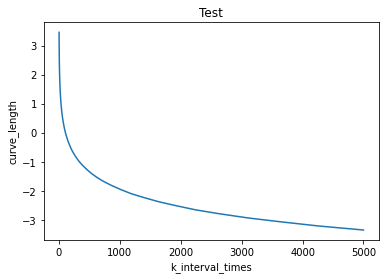

In [8]:
import math
#x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in l:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Test") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(k,y) 
plt.show()

Raw fit results:
poly([ 0.75210526 -0.00122127])
[array([72.81634649]), 2, array([1.23135627, 0.69552983]), 1.0436096431476471e-14]
Fit: A = -0.001[P] + 0.752 (rms residual = 1.2447)


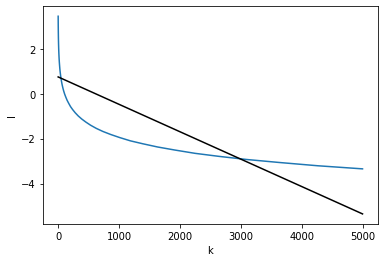

In [11]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k
A = y

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#Data Preprocessing

In [25]:
data = pd.read_csv('/content/DATA.csv')
data.head()

,DATE,SNO.,MAHARASHTRA,ANDHRA PRADESH,TAMIL NADU,KARNATAKA,UTTAR PRADESH,DELHI,WEST BENGAL,GUJARAT,KERALA,UTTARAKHAND
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/04/2020,1.0,33.0,67.0,110.0,9.0,13.0,32.0,37.0,13.0,24.0,7.0
2,02/04/2020,2.0,88.0,38.0,75.0,14.0,11.0,141.0,16.0,1.0,21.0,3.0
3,03/04/2020,3.0,64.0,15.0,102.0,4.0,46.0,93.0,0.0,7.0,9.0,6.0
4,04/04/2020,4.0,148.0,28.0,74.0,16.0,60.0,59.0,0.0,13.0,11.0,6.0


In [26]:
maha = data.MAHARASHTRA
print(maha[1:154])

andhra = data['ANDHRA PRADESH']
print(andhra[1:154])

tamil = data['TAMIL NADU']
print(tamil[1:154])

karna = data.KARNATAKA
print(karna[1:154])

up = data['UTTAR PRADESH']
print(up[1:154])

delhi = data['DELHI']
print(delhi[1:154])

wb = data['WEST BENGAL']
print(wb[1:154])

1         33.0
2         88.0
3         64.0
4        148.0
5        112.0
        ...   
149    14857.0
150    14427.0
151    16286.0
152    16408.0
153    11852.0
Name: MAHARASHTRA, Length: 153, dtype: float64
1         67.0
2         38.0
3         15.0
4         28.0
5         64.0
        ...   
149    10621.0
150    10526.0
151    10548.0
152    10603.0
153    10004.0
Name: ANDHRA PRADESH, Length: 153, dtype: float64
1       110.0
2        75.0
3       102.0
4        74.0
5        86.0
        ...  
149    5981.0
150    5996.0
151    6352.0
152    6495.0
153    5956.0
Name: TAMIL NADU, Length: 153, dtype: float64
1         9.0
2        14.0
3         4.0
4        16.0
5         7.0
        ...  
149    9386.0
150    8960.0
151    8324.0
152    8852.0
153    6495.0
Name: KARNATAKA, Length: 153, dtype: float64
1        13.0
2        11.0
3        46.0
4        60.0
5        44.0
        ...  
149    5391.0
150    5405.0
151    5633.0
152    6175.0
153    4782.0
Name: UTTAR PRADESH,

In [27]:
import pandas
print(pandas.__version__)

1.0.5


In [31]:
# convert dataframe to np.array
import numpy
maha_np_array = data['MAHARASHTRA'].to_numpy()
#maha_np_array = list(numpy.concatenate().flat)) 
print(maha_np_array[1:154])

andhra_np_array = andhra.to_numpy()
print(andhra_np_array[1:154])

tamil_np_array = tamil.to_numpy()
print(tamil_np_array[1:154])

karna_np_array = karna.to_numpy()
print(karna_np_array[1:154])

up_np_array = up.to_numpy()
print(up_np_array[1:154])

delhi_np_array = delhi.to_numpy()
print(delhi_np_array[1:154])

wb_np_array = wb.to_numpy()
print(wb_np_array[1:154])

[   33.    88.    64.   148.   112.   121.   150.   117.   229.   210.
   187.   221.   352.   346.   236.   285.   120.   327.   552.   466.
   552.   431.   778.   390.   811.   440.   522.   728.   597.   583.
  1008.   790.   678.  1567.   984.  1233.  1216.  1089.  1165.  1943.
  1230.  1026.  1495.  1602.  1576.  1606.  2347.  2005.  2078.  2161.
  2345.  2940.  2608.  3041.  2436.  2091.  2190.  2598.  2682.  2940.
  2487.  2358.  2287.  2560.  2933.  2436.  2739.  3007.  2554.  2258.
  3254.  3607.  3493.  3427.  3390.  2786.  2701.  3307.  3752.  3827.
  3874.  3870.  3721.  3214.  3889.  4842.  5024.  6368.  5493.  5257.
  4878.  5537.  6328.  6364.  7074.  6555.  5368.  5134.  6603.  6875.
  7862.  8139.  7827.  4697.  6741.  7975.  8641.  8308.  8348.  9518.
  8240.  8336. 10576.  9895.  9615.  9251.  9431.  7924.  7717.  9211.
 11147. 10320.  9601.  9509.  8968.  7760. 10309. 11514. 10483. 12822.
 12248.  9181. 11088. 12712. 11813. 12608. 12020. 11111.  8493. 11119.
 13165

#MAHARASHTRA



In [ ]:
# inputs to Higuchi Algorithm

# k_value = int(input("Enter the bound og 'k' "))
data_list = maha_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [33116.56333333 16414.08592593  9743.01182432  3578.24302469
  2298.47569444  1909.99001905  1090.81049563   836.62225652
   616.07096836   452.75679525   342.09224345   258.47501795
   196.05613037]


In [ ]:
hfd(data_list)

1.3152317436347447

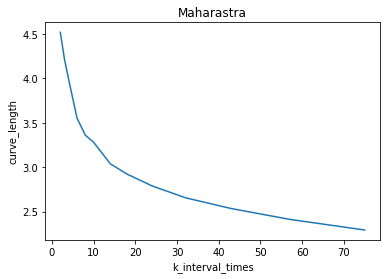

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Maharastra") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#ANDHRA PRADESH

In [32]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = andhra_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [16382.17666667  8478.78518519  5338.59966216  2503.89975309
  1736.4140625   1390.20140952   874.99277616   670.48442093
   488.46126543   376.9601237    293.87584322   191.16774392
   146.30713837]


In [33]:
hfd(data_list)

1.2122976121629008

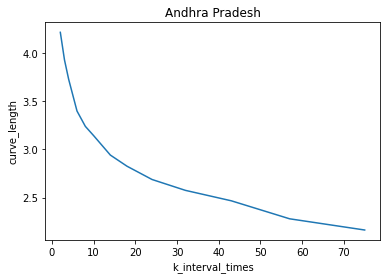

In [34]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Andhra Pradesh") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#TAMIL NADU

In [35]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = tamil_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [7480.13333333 4309.59407407 2948.45945946 1731.50166667 1175.64236111
  862.11794286  549.31849692  419.08208407  319.32351466  241.38952637
  192.24427199  151.15666359  116.6682643 ]


In [36]:
hfd(data_list)

1.113765449516064

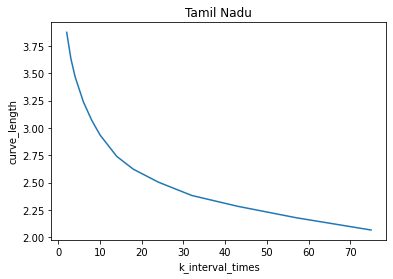

In [37]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Tamil Nadu") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#KARNATAKA

In [60]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = karna_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [13904.28666667  7063.83407407  4092.52702703  2078.86623457
  1311.95225694  1005.67615238   633.13576288   500.29004997
   365.24457948   274.22513835   209.02557008   152.79244896
   113.81147496]


In [61]:
hfd(data_list)

1.23034742019409

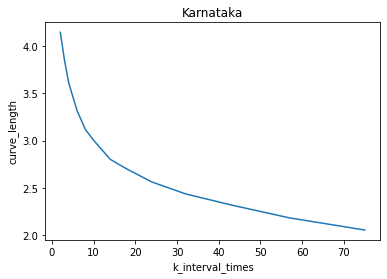

In [62]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Karnataka") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#UTTAR PRADESH

In [57]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = up_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [7276.78333333 3243.11703704 2192.49493243 1144.23512346  801.60677083
  619.39710476  409.40907029  311.50431119  236.86886574  181.04774984
  132.89047086   91.3507746    69.70364207]


In [58]:
hfd(data_list)

1.1797410459829762

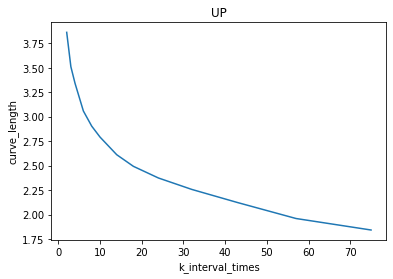

In [59]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("UP") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

# DELHI

In [54]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = delhi_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [9873.94       4670.34074074 2923.4222973  1412.29345679  967.42100694
  738.72361905  445.43275024  331.86145405  231.66219136  157.55635579
  108.49359176   63.36144455   33.64338726]


In [55]:
hfd(data_list)

1.4440076188542394

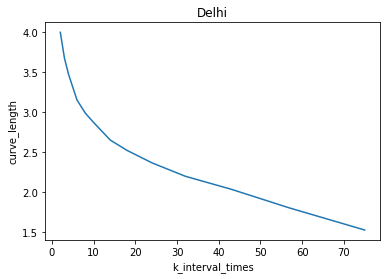

In [56]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Delhi") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#WEST BENGAL

In [51]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = wb_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [3177.24666667 1718.50074074 1172.41891892  685.10950617  485.81684028
  368.98144762  251.3483965   197.57272683  150.60688657  115.52960205
   88.98864251   66.73848364   48.35014163]


In [52]:
hfd(data_list)

1.0802491601018411

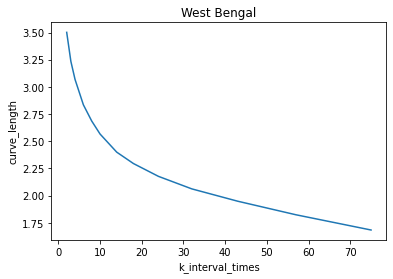

In [53]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("West Bengal") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

#Analysis